# Objective 1

In [13]:
# Importing libraries/modules for
import pandas as pd # handling data
import numpy as np # handling data
import matplotlib.pyplot as plt # plotting data
# Multivariate Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# Evaluating performance and finetuning hyperparameters
from sklearn.metrics import make_scorer, roc_auc_score, average_precision_score, accuracy_score, f1_score, cohen_kappa_score, matthews_corrcoef
from sklearn.model_selection import GridSearchCV, train_test_split
# models to train and test
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
# Inspecting models for figuring out feature importance
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFECV

In [14]:
# reading the training dataset as a Pandas DataFrame
df = pd.read_csv("https://www.ee.iitb.ac.in/~asethi/Dump/MouseTrain.csv")
    # ref: https://stackoverflow.com/a/35598438

Exploratory data analysis

In [15]:
# the amount of empty values in a column that we can handle sufficiently well
null_cap = 0.1
# getting the dimensions of the dataset
shape = df.shape
# we require the column names to identify them
cols = df.columns
# an indexable object with the no. of nulls(zero or nan) in column i at index i
nulls = df.isna().sum()
    # ref: https://datatofish.com/count-nan-pandas-dataframe/
# list of column names to remove from the dataset as they are not useful
to_remove = [[]]
print("# nulls |% nulls|Column Name")
# iterating over all columns
for i in range(df.shape[1]):
    # if it has a non-zero no. of nulls
    if nulls[i] != 0:
        print(nulls[i], "%.2f" %(nulls[i]/shape[0]), cols[i], sep="\t|")
        # and they are greater than 10% of the total samples(training points)
        if nulls[i]/shape[0] > null_cap:
            # then we decide to remove that particular column
            to_remove[0].append(cols[i])
print("\nColumns that have too many null values are unusable hence, we drop them:")
print(*to_remove[0], sep=", ")
# dropping the columns that satisfy the creiterion described above from the dataset
df.drop(to_remove[0], axis=1, inplace=True)
    # ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html

# nulls |% nulls|Column Name
15	|0.02	|ELK_N
4	|0.01	|MEK_N
15	|0.02	|Bcatenin_N
180	|0.24	|BAD_N
195	|0.26	|BCL2_N
60	|0.08	|pCFOS_N
150	|0.20	|H3AcK18_N
180	|0.24	|EGR1_N
180	|0.24	|H3MeK4_N

Columns that have too many null values are unusable hence, we drop them:
BAD_N, BCL2_N, H3AcK18_N, EGR1_N, H3MeK4_N


Columns that have too many null values are not usable because even if we try to impute them we may instead end up with a column that has too little variance (when using mean or mode imputing methods) or it would simply be too costly to impute them and much more economical to just drop them.

In [16]:
# the (subjective) minimum amount of variance a column should have
var_thresh = 0.01
# preparing to remember the names of those columns
to_remove.append([])
cols = df.columns
# an indexable object with the variance of column i at index i
var = df[cols[:-2]].var()
# iterating over the columns having numerical values i.e. not caring about the variance in the columns that define the classes
for i in range(len(var)):
    # if the variance is less than the minimum
    if var[i] < var_thresh:
        # then we decide to remove that column
        to_remove[1].append(cols[i])
print(f"No. of columns with variance less than the threshold ({var_thresh}) are: {len(to_remove[1])}")
print("They are:")
print(*to_remove[1])
print("Since, these columns are relatively similar throughout the dataset, they aren't very useful for classification hence we will drop them too.")
# dropping the columns that satisfy the creiterion described above from the dataset
df.drop(to_remove[1], axis=1, inplace=True)

No. of columns with variance less than the threshold (0.01) are: 41
They are:
BDNF_N pAKT_N pBRAF_N pCREB_N pJNK_N PKCA_N pMEK_N pRSK_N CAMKII_N CREB_N JNK_N MEK_N RSK_N APP_N MTOR_N P38_N AMPKA_N NR2B_N pNUMB_N RAPTOR_N TIAM1_N NUMB_N pGSK3B_N CDK5_N RRP1_N BAX_N ARC_N ERBB4_N nNOS_N Tau_N GFAP_N GluR3_N GluR4_N IL1B_N P3525_N SNCA_N pGSK3B_Tyr216_N SHH_N pS6_N pCFOS_N SYP_N
Since, these columns are relatively similar throughout the dataset, they aren't very useful for classification hence we will drop them too.


Too little variance means that the particular column isn't very good at discriminating among the classe and hence not useful to us for the task of classification.

In [17]:
# checking the covariances of the columns
cormat = abs(df.corr())
cols = df.columns
to_remove.append([])
print("Columns having high correlations:")
# we only need to iterate over the upper triangle of the correlation matrix since it is symmetric and the diagonal elements are all 1
for i in range(cormat.shape[0]-1):
    # if the correlation a column at index i with another at an index > i
    hicorr = cormat.iloc[i][i+1:] > 0.9
    if any(hicorr):
        print(cols[i], " : ", end="")
        print(*cols[i+1:-2][hicorr], sep=", ")
        # we decide to drop that column
        to_remove[2].extend(cols[i+1:-2][hicorr])
print("Columns having high correlations add redundancy, hence we drop all the columns (unique) on the right:")
# this way of collecting the names of the columns ended up giving us the same columns multiple times. We could have used a set to store them but we can also do the following
to_remove[2] = pd.Series(to_remove[2]).drop_duplicates().tolist()
    # ref: https://www.geeksforgeeks.org/python-get-unique-values-list/#:~:text=Method%237%3A%20Using%20pandas
print(*to_remove[2])
# dropping the columns that satisfy the creiterion described above from the dataset
df.drop(to_remove[2], axis=1, inplace=True)

Columns having high correlations:
DYRK1A_N  : ITSN1_N, pERK_N, BRAF_N
ITSN1_N  : pERK_N, BRAF_N
NR1_N  : pNR1_N, Bcatenin_N
pERK_N  : BRAF_N
pNR1_N  : pNR2B_N
Columns having high correlations add redundancy, hence we drop all the columns (unique) on the right:
ITSN1_N pERK_N BRAF_N pNR1_N Bcatenin_N pNR2B_N


Columns having high correlations with each other aren't much useful than just one of them, because their respective weights in the determination of the class would also be related and add unnecessary copmutations in the model.

In [18]:
# collecting all the column names that we have dropped till now to make it easier to drop them on the test dataset
cols_to_remove = []
for i in to_remove:
    cols_to_remove.extend(i)
print(f"Our pre-processing pipeline consitst of removing the following ({len(cols_to_remove)}) columns from the dataset:")
print(*cols_to_remove[:len(cols_to_remove)//3], sep=", ")
print(*cols_to_remove[len(cols_to_remove)//3:2*len(cols_to_remove)//3], sep=", ")
print(*cols_to_remove[2*len(cols_to_remove)//3:], sep=", ")

Our pre-processing pipeline consitst of removing the following (52) columns from the dataset:
BAD_N, BCL2_N, H3AcK18_N, EGR1_N, H3MeK4_N, BDNF_N, pAKT_N, pBRAF_N, pCREB_N, pJNK_N, PKCA_N, pMEK_N, pRSK_N, CAMKII_N, CREB_N, JNK_N, MEK_N
RSK_N, APP_N, MTOR_N, P38_N, AMPKA_N, NR2B_N, pNUMB_N, RAPTOR_N, TIAM1_N, NUMB_N, pGSK3B_N, CDK5_N, RRP1_N, BAX_N, ARC_N, ERBB4_N, nNOS_N
Tau_N, GFAP_N, GluR3_N, GluR4_N, IL1B_N, P3525_N, SNCA_N, pGSK3B_Tyr216_N, SHH_N, pS6_N, pCFOS_N, SYP_N, ITSN1_N, pERK_N, BRAF_N, pNR1_N, Bcatenin_N, pNR2B_N


These are all the columns that we did not find to be useful for our task of classification.

In [19]:
# checking if the classes are balanced or not
print("Classes for binary classification:", df[cols[-2]].value_counts(sort=False), sep="\n")
print("\nClasses for multi-class classification:", df[cols[-1]].value_counts(sort=False), sep="\n")

Classes for binary classification:
Control    435
Ts65Dn     327
Name: Genotype, dtype: int64

Classes for multi-class classification:
Memantine_C/S    225
Memantine_S/C    225
Saline_C/S       180
Saline_S/C       132
Name: Treatment_Behavior, dtype: int64


We observe that the classes are slightly unbalanced (max ratio is 1:1.299) for binary and moderately unbalanced (max ratio is 1:1.705) for the multi-class classification problems.

Dealing with missing variables

In [20]:
    # ref: (provided in the assignment) https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation
    # changed to use the imputer on our dataframe

# initializing the Multivariate-Imputer
imp = IterativeImputer(max_iter=100, random_state=0)
cols = df.columns
# Training/Fitting it with all the completely filled rows and setting its random state
imp.fit(df.dropna()[cols[:-2]])
    # ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html
IterativeImputer(random_state=0)
# transforming our dataset by imputing the missing values
df_imputed = pd.DataFrame(imp.transform(df[cols[:-2]]))

In [21]:
# re-labelling the columns of the transformed dataset since the imputation generated a numpy array which doesn't store the labels
temp = df_imputed.set_axis(cols[:-2], axis=1)
    # ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_axis.html#pandas-dataframe-set-axis
# joining the two columns that contain the class information to the current dataframs
temp[cols[-2:]] = df[cols[-2:]]
# re-naming for preference/ease-of-use
df = temp

Regarding choice of metrics:

Binary Classification: Since the classes are imbalanced accuracy isn't a good metric. We would be using AUC (Area Under Receiver Operaing Charecteristic Curve) [1] and PR AUC (Precision-Recall Area Under Curve) or Average Precision [1].

Multi-class Classification: For the multi-class classification problem we would be using Cohen's Kappa score [2] and Matthew' Correlation coefficient [2].

References:
*  [1] https://neptune.ai/blog/evaluation-metrics-binary-classification
*  [2] https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd

In [22]:
# defining function for the pre-processing required:
    # removing the identified columns, and
    # normalizeing it obtain near-zero mean and near-zero standard deviation

# function that returns a normalized dataframe without affecting the columns that contain the class information which is assumed to be in the last few columns
# Note that this function won't work if the dataframe doesn't have a column for class since slicing till -0 is the same as an empty indexable object e.g. [], {}, etc.
def normalized(df, num_class_cols=1):
    # create a copy of the dataframe
    temp = df.copy()
    # iterate over the columns which do not have any class information
    for col in df.columns[:-num_class_cols if num_class_cols else 0]:
        # normalizing column by column by subtracting the mean and dividing by the standard deviation
        temp[col] = (temp[col] - temp[col].mean()) / temp[col].std()
    # returing the copied array that was normlazied above
    return temp

# the function that does the pre-processing tasks stated at the top
def pre_processing(df, cols_to_remove, to_normalize=True):
    # first remove the columns that are perceived to be useless
    temp = df.drop(cols_to_remove, axis=1)
    # then return either a normalized or un-normalized dataframe depending on the user's preference
    return normalized(temp, 2) if to_normalize else temp

In [23]:
# normalizing our current dataframe
df = normalized(df, 2)

In [24]:
# defining a constant for the k-fold cross-validation
k_fold = 5
# x and y for the task of binary classification. y needs to be integer hence assigned 0 and 1 w.l.o.g.
binary_x, binary_y = df[cols[:-2]], df['Genotype'].replace({'Control':0, 'Ts65Dn':1})
    # ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html
# metrics that would be used for checking the performance of the binary classification task
binary_metrics = {
    'AUC': make_scorer(roc_auc_score),
    'PR': make_scorer(average_precision_score),
    'ACC': 'accuracy',
    'F1': make_scorer(f1_score)
}
    # ref: https://scikit-learn.org/stable/modules/model_evaluation.html#multimetric-scoring,
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
# the class labels
binary_labels = df['Genotype'].unique()
# dictionary to store the GridSearchCV object of the models used for binary classification
binary_search = {}
# x and y for the task of multi-class classification. y needs to be integer hence assigned 0, 1, 2, and 3 w.l.o.g.
multi_x, multi_y = binary_x, df['Treatment_Behavior'].replace({'Memantine_C/S':0, 'Memantine_S/C':1, 'Saline_C/S':2, 'Saline_S/C':3})
# metrics that would be used for checking the performance of the multi-class classification task
multi_metrics = {
    'kappa': make_scorer(cohen_kappa_score),
    'MCC': make_scorer(matthews_corrcoef),
    'ACC': 'accuracy',
    'F1': make_scorer(f1_score, average = 'weighted')
}
# the class lables
multi_labels = df['Treatment_Behavior'].unique()
# dictionary to store the GridSearchCV object of the models used for multi-class classification
multi_search = {}

Linear SVM model

In [ ]:
    # ref: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html,
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# bookkeeping tasks
binary_search['LinearSVM'], multi_search['LinearSVM'] = [], []
# param grid of parameters to vary (regularization)
params = {
    'C': [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500] 
}
# finding the effect of using different metrics for performance measurement
for i in binary_metrics.keys():
    binary_search['LinearSVM'].append(GridSearchCV(LinearSVC(), params, scoring=binary_metrics[i], cv=k_fold).fit(binary_x, binary_y))
for i in multi_metrics.keys():
    multi_search['LinearSVM'].append(GridSearchCV(LinearSVC(), params, scoring=multi_metrics[i], cv=k_fold).fit(multi_x, multi_y))
# Out put of this code cell had a lot of convergence warning saying that the solution did nor converge and urging to increase the max no. of iterations,
# but we obtained reasonable performance without that as well. Hence the output is not shown here.

In [ ]:
# printing the best hyperparameters and the corressponding best score obtained via GridSearchCV
print("Binary Classification:\n")
print("Metric\t|Hyperparams\t|Best score")
for idx, key in enumerate(binary_metrics.keys()):
    print(key, binary_search['LinearSVM'][idx].best_params_, binary_search['LinearSVM'][idx].best_score_, sep="\t|")
print("\nMulti-class Classification:\n")
print("Metric\t|Hyperparams\t|Best score")
for idx, key in enumerate(multi_metrics.keys()):
    print(key, multi_search['LinearSVM'][idx].best_params_, multi_search['LinearSVM'][idx].best_score_, sep="\t|")

Binary Classification:

Metric	|Hyperparams	|Best score
AUC	|{'C': 500}	|0.5981118881118881
PR	|{'C': 500}	|0.5198909642636487
ACC	|{'C': 200}	|0.5878310973512212
F1	|{'C': 100}	|0.48383651350968415

Multi-class Classification:

Metric	|Hyperparams	|Best score
kappa	|{'C': 0.5}	|0.5600862701498186
MCC	|{'C': 0.5}	|0.5757898942338301
ACC	|{'C': 0.5}	|0.6757309941520468
F1	|{'C': 0.5}	|0.6613673024656389


RBF kernel SVM. RBF kernel is the default for SVC

In [ ]:
    # ref: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# No warnings encoutered hence output shown in the same code cell
binary_search['RBF_SVM'], multi_search['RBF_SVM'] = [], []
# gamma = -1/sigma^2 hence directly proportional to kernel width and C is for regularization
params = {
    'gamma': [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500],
    'C': [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500]
}
print("Binary Classification:\n")
print("Metric\t|\tHyperparams\t\t|Best score")
for i in binary_metrics.keys():
    binary_search['RBF_SVM'].append(GridSearchCV(SVC(), params, scoring=binary_metrics[i], cv=k_fold).fit(binary_x, binary_y))
    print(i, binary_search['RBF_SVM'][-1].best_params_, binary_search['RBF_SVM'][-1].best_score_, sep="\t|")
print("\nMulti-class Classification:\n")
print("Metric\t|\tHyperparams\t\t|Best score")
for i in multi_metrics.keys():
    multi_search['RBF_SVM'].append(GridSearchCV(SVC(), params, scoring=multi_metrics[i], cv=k_fold).fit(multi_x, multi_y))
    print(i, multi_search['RBF_SVM'][-1].best_params_, multi_search['RBF_SVM'][-1].best_score_, sep="\t|")

Binary Classification:

Metric	|	Hyperparams		|Best score
AUC	|{'C': 200, 'gamma': 0.005}	|0.6616325054256089
PR	|{'C': 500, 'gamma': 0.005}	|0.5562675244497618
ACC	|{'C': 200, 'gamma': 0.005}	|0.6760491916064671
F1	|{'C': 200, 'gamma': 0.005}	|0.5924915902153999

Multi-class Classification:

Metric	|	Hyperparams		|Best score
kappa	|{'C': 10, 'gamma': 0.05}	|0.6419919340659399
MCC	|{'C': 10, 'gamma': 0.05}	|0.6517127967967827
ACC	|{'C': 10, 'gamma': 0.05}	|0.7361541107671138
F1	|{'C': 10, 'gamma': 0.05}	|0.7315871710497015


Neural Network with single ReLU hidden layer. Softmax output is the default for MLPClassifier

In [ ]:
    # ref: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
# Convergence warnings not shown
binary_search['NN'], multi_search['NN'] = [], []
# hidden_layersizes_constructs as many hidden layers as the number of elements in the iterable, hence for a single hidden layes with variable no. of neurons
# a list containing a single integer is passed every time the hyperparameters are updated
# power_t decays the learning rate (related to weight decay) hence decided to vary the initial learning rate (learning_rate_init) as well
params = {
    'hidden_layer_sizes': [[i] for i in range(10, 110, 10)],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1, 1],
    'power_t': [0.0001, 0.001, 0.01, 0.1, 1]
}
print("Binary Classification:\n")
print("Metric\t|\t\t\t\tHyperparams\t\t\t\t\t|Best score")
for i in binary_metrics.keys():
    binary_search['NN'].append(GridSearchCV(MLPClassifier(solver='sgd', learning_rate='invscaling'), params, scoring=binary_metrics[i], cv=k_fold).fit(binary_x, binary_y))
    print(i, binary_search['NN'][-1].best_params_, binary_search['NN'][-1].best_score_, sep="\t|")
print("\nMulti-class Classification:\n")
print("Metric\t|\t\t\t\tHyperparams\t\t\t\t\t|Best score")
for i in multi_metrics.keys():
    multi_search['NN'].append(GridSearchCV(MLPClassifier(solver='sgd', learning_rate='invscaling'), params, scoring=multi_metrics[i], cv=k_fold).fit(multi_x, multi_y))
    print(i, multi_search['NN'][-1].best_params_, multi_search['NN'][-1].best_score_, sep="\t|")

In [ ]:
print("Binary Classification:\n")
print("Metric\t|\t\t\t\tHyperparams\t\t\t\t\t|Best score")
for idx, key in enumerate(binary_metrics.keys()):
    print(key, binary_search['NN'][idx].best_params_, binary_search['NN'][idx].best_score_, sep="\t|")
print("\nMulti-class Classification:\n")
print("Metric\t|\t\t\t\tHyperparams\t\t\t\t\t|Best score")
for idx, key in enumerate(multi_metrics.keys()):
    print(key, multi_search['NN'][idx].best_params_, multi_search['NN'][idx].best_score_, sep="\t|")

Binary Classification:

Metric	|				Hyperparams					|Best score
AUC	|{'hidden_layer_sizes': [10], 'learning_rate_init': 0.1, 'power_t': 0.1}	|0.6849754842858291
PR	|{'hidden_layer_sizes': [20], 'learning_rate_init': 0.1, 'power_t': 0.1}	|0.5408492640044138
ACC	|{'hidden_layer_sizes': [70], 'learning_rate_init': 0.1, 'power_t': 0.0001}	|0.6617303061575507
F1	|{'hidden_layer_sizes': [60], 'learning_rate_init': 0.001, 'power_t': 1}	|0.6147153397843974

Multi-class Classification:

Metric	|				Hyperparams					|Best score
kappa	|{'hidden_layer_sizes': [50], 'learning_rate_init': 0.1, 'power_t': 0.001}	|0.6330181116106273
MCC	|{'hidden_layer_sizes': [50], 'learning_rate_init': 0.01, 'power_t': 0.001}	|0.6546797804287606
ACC	|{'hidden_layer_sizes': [50], 'learning_rate_init': 0.01, 'power_t': 0.01}	|0.7362229102167183
F1	|{'hidden_layer_sizes': [40], 'learning_rate_init': 0.1, 'power_t': 0.01}	|0.7301942088426772


Random Forest

In [ ]:
    # ref: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# No warnings encoutered hence output shown in the same code cell
binary_search['RF'], multi_search['RF'] = [], []
# n_estimators is the number of trees but was not asked to vary hence reduced from the default 100 to 10 in order to train in a reasonable amount of time
# max_depth is the max tree depth
# max_features is the maximum no. of nodes per leaf
params = {
    'max_depth': list(range(10, 100, 10)),
    'max_features': [i/100 for i in range(10, 100, 10)]
}
print("Binary Classification:\n")
print("Metric\t|\t\tHyperparams\t\t|Best score")
for i in binary_metrics.keys():
    binary_search['RF'].append(GridSearchCV(RandomForestClassifier(n_estimators=10), params, scoring=binary_metrics[i], cv=k_fold).fit(binary_x, binary_y))
    print(i, binary_search['RF'][-1].best_params_, binary_search['RF'][-1].best_score_, sep="\t|")
print("\nMulti-class Classification:\n")
print("Metric\t|\t\tHyperparams\t\t|Best score")
for i in multi_metrics.keys():
    multi_search['RF'].append(GridSearchCV(RandomForestClassifier(n_estimators=10), params, scoring=multi_metrics[i], cv=k_fold).fit(multi_x, multi_y))
    print(i, multi_search['RF'][-1].best_params_, multi_search['RF'][-1].best_score_, sep="\t|")

Binary Classification:

Metric	|		Hyperparams		|Best score
AUC	|{'max_depth': 50, 'max_features': 0.4}	|0.6343686198858612
PR	|{'max_depth': 10, 'max_features': 0.7}	|0.549248321218047
ACC	|{'max_depth': 90, 'max_features': 0.8}	|0.6405400756793946
F1	|{'max_depth': 10, 'max_features': 0.9}	|0.553626401912769

Multi-class Classification:

Metric	|		Hyperparams		|Best score
kappa	|{'max_depth': 40, 'max_features': 0.7}	|0.6067449836336141
MCC	|{'max_depth': 70, 'max_features': 0.7}	|0.6069665892023277
ACC	|{'max_depth': 80, 'max_features': 0.9}	|0.7008771929824561
F1	|{'max_depth': 60, 'max_features': 0.8}	|0.6960696100052983


We observe that roughly every model gives better performance for multi-class classification. This could be because of the way the multi-class metrics are defined. Amongst them, the Neural Network with a single ReLU hidden layer and Softmax activation gives the best performance for both binary and multi-class classification for the metrics on which we have evaluated the models.

Checking Feature Importance

In [ ]:
# using the permutation importance function from sklearn that computes importance based on the decrease in model score when a feature is randomly shuffled
    # ref: https://scikit-learn.org/stable/modules/permutation_importance.html
importance = []
importance.append([permutation_importance(binary_search['LinearSVM'][i], binary_x, binary_y) for i in range(4)])
importance.append([permutation_importance(binary_search['RBF_SVM'][i], binary_x, binary_y) for i in range(4)])
importance.append([permutation_importance(binary_search['NN'][i], binary_x, binary_y) for i in range(4)])
importance.append([permutation_importance(binary_search['RF'][i], binary_x, binary_y) for i in range(4)])

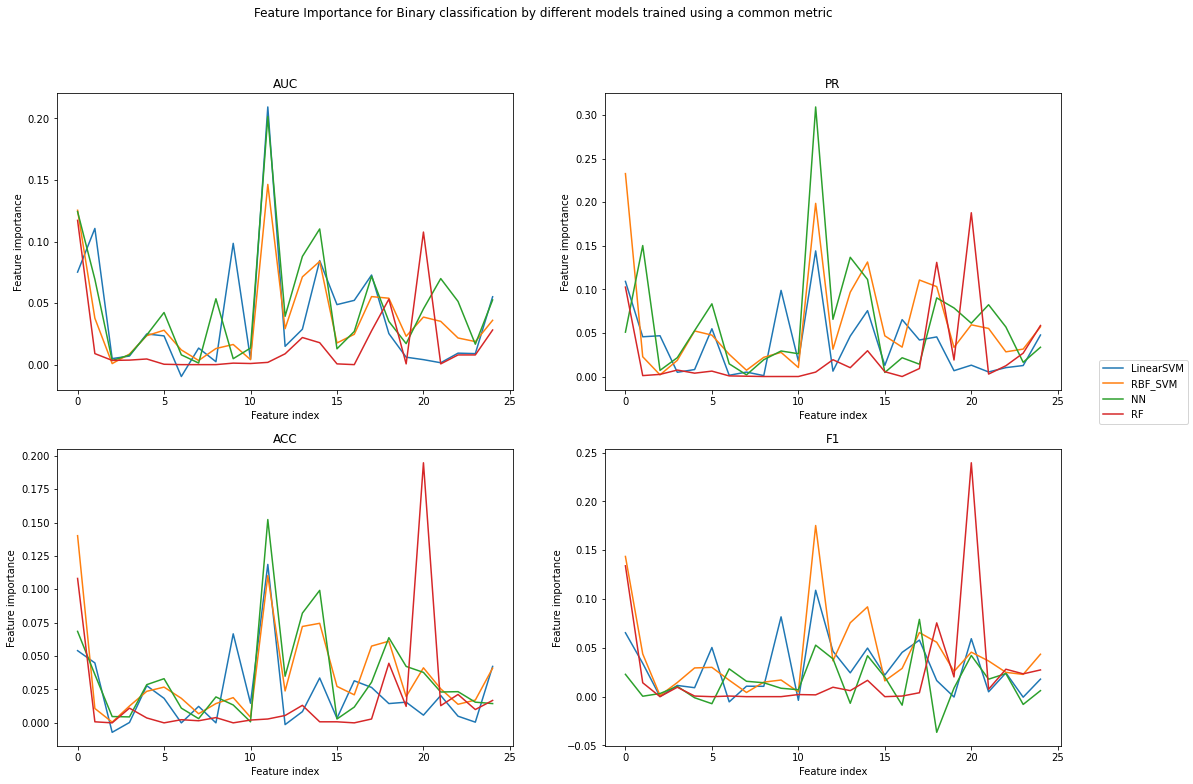

In [ ]:
# plotting the feature importance of the different models grouped together under the metric which was used for evaluation
keys = list(binary_metrics.keys())
models = list(binary_search.keys())
fig = plt.figure(figsize=(18, 12))
for j in range(4):
    ax = fig.add_subplot(2, 2, j+1)
    for i in range(4):
        ax.plot(importance[i][j]['importances_mean'])
    ax.set(xlabel='Feature index', ylabel='Feature importance')
    ax.set_title(keys[j])
fig.suptitle('Feature Importance for Binary classification by different models trained using a common metric')
    # ref: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
fig.legend(labels=models, loc="center right")
    # ref: https://www.geeksforgeeks.org/how-to-create-a-single-legend-for-all-subplots-in-matplotlib/
plt.show()

We obsereve that for binary classification Linear SVM, RBF kernel SVM and Neural Network assign more importance to almost the same features. However the Random Forest Classifier assigns feature importance differently compared to the other three models.

In [ ]:
importance.append([permutation_importance(multi_search['LinearSVM'][i], multi_x, multi_y) for i in range(4)])
importance.append([permutation_importance(multi_search['RBF_SVM'][i], multi_x, multi_y) for i in range(4)])
importance.append([permutation_importance(multi_search['NN'][i], multi_x, multi_y) for i in range(4)])
importance.append([permutation_importance(multi_search['RF'][i], multi_x, multi_y) for i in range(4)])

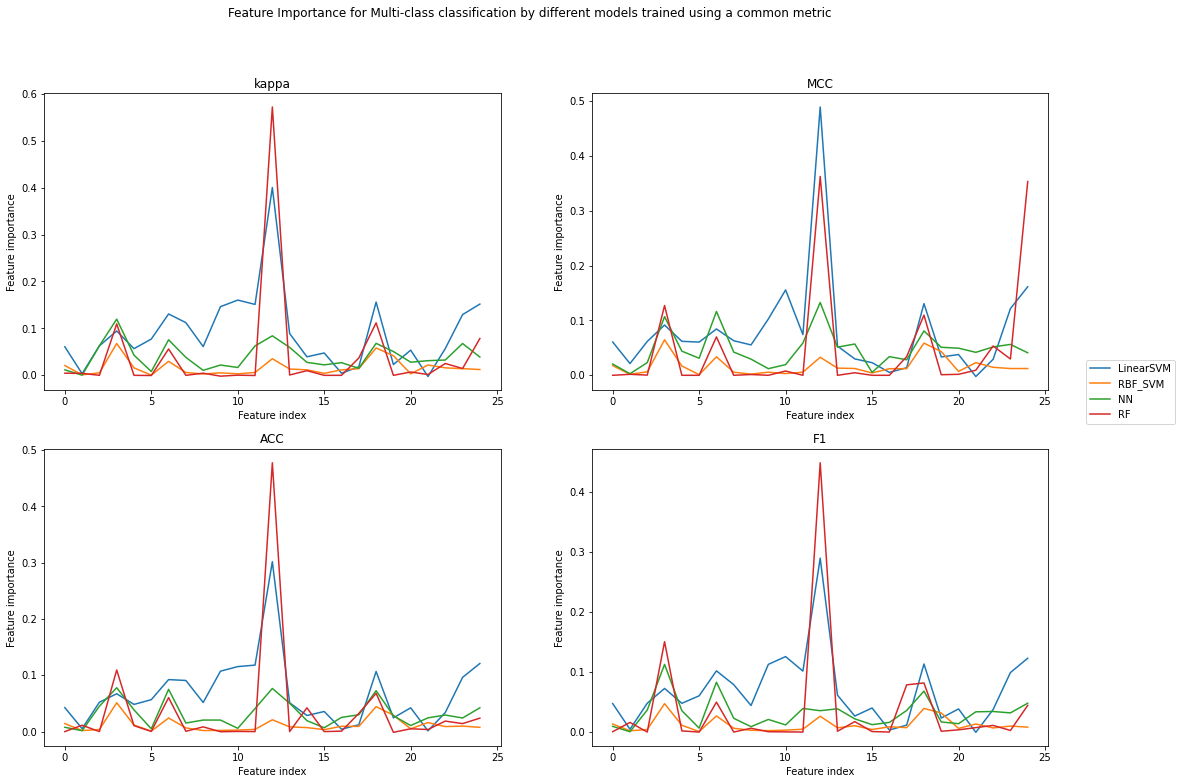

In [ ]:
keys = list(multi_metrics.keys())
models = list(multi_search.keys())
fig = plt.figure(figsize=(18, 12))
for j in range(4):
    ax = fig.add_subplot(2, 2, j+1)
    for i in range(4):
        ax.plot(importance[i+4][j]['importances_mean'])
    ax.set(xlabel='Feature index', ylabel='Feature importance')
    ax.set_title(keys[j])
fig.suptitle('Feature Importance for Multi-class classification by different models trained using a common metric')
fig.legend(labels=models, loc="center right")
plt.show()

For the multi-class classification, the pairs Linear SVM, Random Forest and RBF kernel SVM, Neural Network assign similar importances to different features.

Recursively removing/eliminating features using RFECV

In [27]:
# RFECV can only work if the estimator has either the coef_ attribute (Linear SVM) or the featre_imporatnces_ attribute (Random Forest)
# It provides with a ranking based on the attributed mentioned above
    # ref: (provided in the assignment) https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
selector = []
# the models are not only trained with the rank 1 features but also with the optimum hyperparameters
# convergence warnings of Linear SVM hidden
selector.append(RFECV(LinearSVC(C=500)).fit(binary_x, binary_y))
selector.append(RFECV(LinearSVC(C=0.5)).fit(multi_x, multi_y))

selector.append(RFECV(RandomForestClassifier(n_estimators=10, max_depth=90, max_features=0.7)).fit(binary_x, binary_y))
selector.append(RFECV(RandomForestClassifier(n_estimators=10, max_depth=80, max_features=0.9)).fit(multi_x, multi_y))

In [ ]:
print(*[selector[i].ranking_ for i in range(4)], sep="\n")

[ 1  1  1  5  1  1 13  1 11  1  3  1  6  8  1  4  1  2  1  7  1 12 10  9
  1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 3 1 1 1]
[ 1  6  7  1  4  3  5 12 13 11  8  2  1  1  1 10  9  1  1  1  1  1  1  1
  1]
[ 1  1  9  1  1  8  1  7  1  4  1  3  1  6  1  2  5  1  1 10  1  1  1  1
  1]


In [ ]:
# Since a lot of them are assigned the rank of 1, we would only consider these features for training the models
# every model requires different features hence, we need to define seperate training datasets for them
binary_x_trimmed_LinearSVM = binary_x[cols[:-2][selector[0].ranking_ == 1]]
multi_x_trimmed_LinearSVM = multi_x[cols[:-2][selector[1].ranking_ == 1]]
binary_x_trimmed_RF = binary_x[cols[:-2][selector[2].ranking_ == 1]]
multi_x_trimmed_RF = multi_x[cols[:-2][selector[3].ranking_ == 1]]

In [ ]:
# since we need to find the imporvement (if any) we need validation data, therefore using train_test_split witht the default test size of 0.25 the total no. of samples
dataset = [ train_test_split(x, y, ) for (x, y) in [(binary_x_trimmed_LinearSVM, binary_y), (multi_x_trimmed_LinearSVM, multi_y), (binary_x_trimmed_RF, binary_y), (multi_x_trimmed_RF, multi_y)] ]
# training the models and storing their predictions
model_b1 = LinearSVC(C=500).fit(dataset[0][0], dataset[0][2])
arg_b1 = (dataset[0][3], model_b1.predict(dataset[0][1]))
model_m1 = LinearSVC(C=0.5).fit(dataset[1][0], dataset[1][2])
arg_m1 = (dataset[1][3], model_m1.predict(dataset[1][1]))
model_b2 = RandomForestClassifier(n_estimators=10, max_depth=90, max_features=0.7).fit(dataset[2][0], dataset[2][2])
arg_b2 = (dataset[2][3], model_b2.predict(dataset[2][1]))
model_m2 = RandomForestClassifier(n_estimators=10, max_depth=80, max_features=0.9).fit(dataset[3][0], dataset[3][2])
arg_m2 = (dataset[3][3], model_m2.predict(dataset[3][1]))

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
# calculating the scores given by all the relevant metrics for the model and the type of classification problem
scores = []
scores.append([ roc_auc_score(*y) for y in (arg_b1, arg_b2) ])
scores.append([ average_precision_score(*y) for y in (arg_b1, arg_b2) ])
scores.append([ accuracy_score(*y) for y in (arg_b1, arg_b2) ])
scores.append([ f1_score(*y) for y in (arg_b1, arg_b2) ])

scores.append([ cohen_kappa_score(*y) for y in (arg_m1, arg_m2) ])
scores.append([ matthews_corrcoef(*y) for y in (arg_m1, arg_m2) ])
scores.append([ accuracy_score(*y) for y in (arg_m1, arg_m2) ])
scores.append([ f1_score(*y, average="weighted") for y in (arg_m1, arg_m2) ])

In [ ]:
# displaying the performance
for k in range(2):
    keys = [list(binary_metrics.keys()), list(multi_metrics.keys())][k]
    print(["Binary", "Multi-class"][k], "classification:")
    print()
    print("Model\t|Metric\t|Previous\t\t|Current\t\t|Improvement")
    print()
    for j in range(2):
        print(["SVM", "RF"][j], end="")
        d = [binary_search, multi_search][k]
        for i in range(4):
            print(f"\t|{keys[i]}\t|{d[['LinearSVM', 'RF'][j]][i].best_score_}\t|{scores[4*k+i][j]}\t|{scores[4*k+i][j]/d[['LinearSVM', 'RF'][j]][i].best_score_}")
        print() 

Binary classification:

Model	|Metric	|Previous		|Current		|Improvement

SVM	|AUC	|0.5933502130053855	|0.6220159151193634	|1.048311606679608
	|PR	|0.5084059182190005	|0.5352229644340134	|1.0527473132275011
	|ACC	|0.6102081183350533	|0.6282722513089005	|1.0296032327841442
	|F1	|0.5258511264238691	|0.5748502994011977	|1.0931806941454227

RF	|AUC	|0.6343686198858612	|0.9227586206896551	|1.4546094995299144
	|PR	|0.549248321218047	|0.8768347045624533	|1.596426735757572
	|ACC	|0.6405400756793946	|0.9319371727748691	|1.454924068234765
	|F1	|0.553626401912769	|0.9103448275862068	|1.6443305890777287

Multi-class classification:

Model	|Metric	|Previous		|Current		|Improvement

SVM	|kappa	|0.5600862701498186	|0.8571642237511217	|1.5304146333061104
	|MCC	|0.5883074525356524	|0.8575867319126432	|1.457718626912468
	|ACC	|0.6757309941520468	|0.8952879581151832	|1.324917705215892
	|F1	|0.6613673024656389	|0.8960127954760565	|1.3547884694868304

RF	|kappa	|0.6067449836336141	|0.964743234762063	|1.5900

We observe massive improvement in both the models for which we could use RFECV, except for the binary classification problem using linear SVM where the improvement was slightly less than all the other cases.

Testing the promising models: Linear SVM and Random Forest Classifier

In [ ]:
# directly obtaining the pre-processed test data (useless columns removed and normalized!)
dftest = pre_processing(pd.read_csv("https://www.ee.iitb.ac.in/~asethi/Dump/MouseTest.csv"), cols_to_remove)

In [ ]:
# the models each required a different set of features for the best performance
x_test = [ dftest[cols[:-2][selector[i].ranking_ == 1]] for i in range(len(selector)) ]
binary_y_test = dftest['Genotype'].replace({'Control':0, 'Ts65Dn':1})
multi_y_test = dftest['Treatment_Behavior'].replace({'Memantine_C/S':0, 'Memantine_S/C':1, 'Saline_C/S':2, 'Saline_S/C':3})

In [ ]:
# training the promising models on the whole training dataset
promising_models = [
    LinearSVC(C=500).fit(binary_x_trimmed_LinearSVM, binary_y),
    LinearSVC(C=0.5).fit(multi_x_trimmed_LinearSVM, multi_y),
    RandomForestClassifier(n_estimators=10, max_depth=90, max_features=0.7).fit(binary_x_trimmed_RF, binary_y),
    RandomForestClassifier(n_estimators=10, max_depth=90, max_features=0.7).fit(multi_x_trimmed_RF, multi_y)
]

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
# predicting the test classes
binary_preds = [promising_models[i].predict(x_test[i]) for i in [0, 2]]
multi_preds = [promising_models[i].predict(x_test[i]) for i in [1, 3]]

In [ ]:
# calculating the relevant scores
binary_scores = [
    [ roc_auc_score(binary_y_test, binary_preds[i]) for i in range(2) ],
    [ average_precision_score(binary_y_test, binary_preds[i]) for i in range(2) ],
    [ accuracy_score(binary_y_test, binary_preds[i]) for i in range(2) ],
    [ f1_score(binary_y_test, binary_preds[i]) for i in range(2) ]
]
multi_scores = [
    [ cohen_kappa_score(multi_y_test, multi_preds[i]) for i in range(2) ],
    [ matthews_corrcoef(multi_y_test, multi_preds[i]) for i in range(2) ],
    [ accuracy_score(multi_y_test, multi_preds[i]) for i in range(2) ],
    [ f1_score(multi_y_test, multi_preds[i], average="weighted") for i in range(2) ]
]

In [ ]:
# displaying the performance
for k in range(2):
    keys = [list(binary_metrics.keys()), list(multi_metrics.keys())][k]
    print(["Binary", "Multi-class"][k], "classification:")
    print()
    print("Model\t|Metric\t|Testing score")
    print()
    scores = [binary_scores, multi_scores][k]
    for j in range(2):
        print(["SVM", "RF"][j], end="")
        for i in range(4):
            print(f"\t|{keys[i]}\t|{scores[i][j]}")
        print() 

Binary classification:

Model	|Metric	|Testing score

SVM	|AUC	|0.7148148148148149
	|PR	|0.5617429193899782
	|ACC	|0.7155555555555555
	|F1	|0.6666666666666666

RF	|AUC	|0.7333333333333333
	|PR	|0.6036363636363636
	|ACC	|0.7555555555555555
	|F1	|0.6706586826347306

Multi-class classification:

Model	|Metric	|Testing score

SVM	|kappa	|0.5033504138746551
	|MCC	|0.5102542789277521
	|ACC	|0.6266666666666667
	|F1	|0.6220479581469207

RF	|kappa	|0.5172824791418356
	|MCC	|0.5297496244359731
	|ACC	|0.64
	|F1	|0.6249704178115709



Contrary to what we found earlier, Linear SVM gives better performance on the test data even when it showed less improvement in performance on the training data.

# Objective 2

In [ ]:
# Importing libraries/modules for
import pandas as pd # handling data
from torch.nn import Sequential # making the feature extractor
from torchvision.models import resnet18, ResNet18_Weights # getting the pre-trained model/weights
# models to train and tets
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
# finetune hyperparameters
from sklearn.model_selection import GridSearchCV
# calculate and display performance
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
# access the image dataset that has been uploaded to google drive
from google.colab import drive
drive.mount('/content/gdrive')
    # ref: https://www.marktechpost.com/2019/06/07/how-to-connect-google-colab-with-google-drive/

Mounted at /content/gdrive


The following code from ###---start---### to ###---end---### was copied entirely from the tutorial on transfer learning on pytorch available at: (provided in the assignment) https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html.

The only change made was the value of the variable 'data_dir', which is supposed to be the path to the directory where all the images are stored in a particular format.

In [ ]:
##################------------------start------------------##################

# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gdrive/MyDrive/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


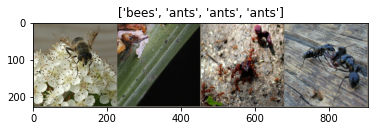

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5751 Acc: 0.7049
val Loss: 0.2820 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.5393 Acc: 0.7664
val Loss: 0.2871 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.5149 Acc: 0.7951
val Loss: 0.2104 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.4857 Acc: 0.8033
val Loss: 0.7928 Acc: 0.7386

Epoch 4/24
----------
train Loss: 0.4580 Acc: 0.8115
val Loss: 0.1628 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4266 Acc: 0.8238
val Loss: 0.2304 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.2710 Acc: 0.8770
val Loss: 0.3904 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.2978 Acc: 0.8934
val Loss: 0.3399 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.2847 Acc: 0.8852
val Loss: 0.3223 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.4385 Acc: 0.8279
val Loss: 0.2866 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.2854 Acc: 0.8811
val Loss: 0.2900 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3467 Acc: 0.8320
val Loss: 0.2605 Acc: 0.9412

Ep

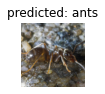

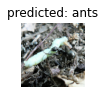

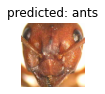

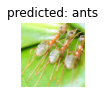

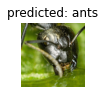

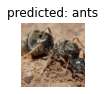

In [ ]:
visualize_model(model_ft)

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5785 Acc: 0.7254
val Loss: 0.2142 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4468 Acc: 0.7951
val Loss: 0.3078 Acc: 0.8627

Epoch 2/24
----------
train Loss: 0.4989 Acc: 0.7623
val Loss: 0.1990 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.3896 Acc: 0.8320
val Loss: 0.1690 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.5966 Acc: 0.7377
val Loss: 0.1940 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.5482 Acc: 0.7705
val Loss: 0.1936 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.4460 Acc: 0.7951
val Loss: 0.2064 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3146 Acc: 0.8689
val Loss: 0.1837 Acc: 0.9673

Epoch 8/24
----------
train Loss: 0.2593 Acc: 0.8893
val Loss: 0.1792 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4056 Acc: 0.8238
val Loss: 0.1808 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3796 Acc: 0.7869
val Loss: 0.1808 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.4000 Acc: 0.8197
val Loss: 0.2007 Acc: 0.9346

Ep

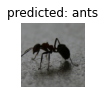

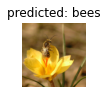

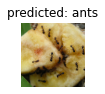

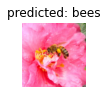

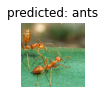

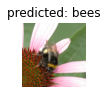

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()
##################------------------end------------------##################

As we can see from the ouputs of the above code cells, the code from the tutorial is running prpoerly in our environment.

Creating a feature extractor

In [ ]:
# Creating a feature extractor that has all the layers of the pre-trained resnet18 except for the last two.
# This would give us an output of 512 features per imput image.
resnet_features = Sequential(*list(resnet18(weights=ResNet18_Weights).children())[:-2])
    # ref: https://stackoverflow.com/a/55098265

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Defining a function to extract features from an image

In [ ]:
# function to extract the features of a single image
def features(image, feature_extractor=resnet_features):
    # returns a dataframe with shape (1, 512) containing the 512 features which are given as input the final layer of resnet18
    # the [None, :] and [:, :, 0, 0] are done to increase and decrease the no. of dimensions of the tensor/numpy array to satisfy the requirements
    return pd.DataFrame(feature_extractor(image[None, :]).detach().numpy()[:, :, 0, 0])
        # ref: https://sparrow.dev/adding-a-dimension-to-a-tensor-in-pytorch/

Trying out different models on the extracted features

In [ ]:
# creating a dictionary with both the training and validation datasets
dataset = {'train': pd.DataFrame(), 'val': pd.DataFrame()}
# iterating over training and validation keys for the image_datasets and dataset dictionaries
for x in ['train', 'val']:
    # need seperate holder for the class column
    classes = []
    # iterating over the train or val images
    for image, cl in image_datasets[x]:
        # adding the image features from the feature extractor to the dataset
        # ignore_index=True makes sure the the rwo labels of the dataframe are integers from 0 to n-1
        dataset[x] = pd.concat((dataset[x],features(image)), ignore_index=True)
            # ref: https://pandas.pydata.org/docs/reference/api/pandas.concat.html
        # appending the corresponding class
        classes.append(cl)
    # adding the class column to the dataset
    dataset[x]['Class'] = classes
    # normalizing the dataset (0 mean and 1 std dev)
    dataset[x] = normalized(dataset[x], 1)
    # randomly shuffling the dataframe, this was done because in the image_datasets, the images were present in an oredered mannner
    # where the images of second class only begun after the images of the first class were exhausted
    dataset[x] = dataset[x].sample(frac = 1)
        # ref: https://www.geeksforgeeks.org/pandas-how-to-shuffle-a-dataframe-rows/

In [ ]:
# using GridSearchCV and storing the results as before
x_train, y_train = dataset['train'].drop(['Class'], axis=1), dataset['train']['Class']
results = []

params = {
    'C': [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500]
}
results.append(GridSearchCV(LogisticRegression(), params, cv=k_fold).fit(x_train, y_train))
    # ref: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

params = {
    'gamma': [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500],
    'C': [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500]
}
results.append(GridSearchCV(SVC(), params, cv=k_fold).fit(x_train, y_train))

# this time we were asked to vary the no. of trees (n_estimators) and the max tree depth (max_depth)
params = {
    'n_estimators': list(range(2, 40, 2)),
    'max_depth': list(range(10, 100, 10))
}
results.append(GridSearchCV(RandomForestClassifier(), params, cv=k_fold).fit(x_train, y_train))

In [ ]:
# displaying the performance
for i in range(3):
    print(["L2 Regularized Logistic Regression:", "RBF kernel SVM", "Random Forest Classifier"][i])
    print(results[i].best_params_, results[i].best_score_, sep="\t")

L2 Regularized Logistic Regression:
{'C': 0.001}	0.5569727891156464
RBF kernel SVM
{'C': 1, 'gamma': 0.005}	0.5982993197278911
Random Forest Classifier
{'max_depth': 30, 'n_estimators': 24}	0.59421768707483


In [ ]:
# training the required models with the optimum hyperparmeters
models = [
    LogisticRegression(C=0.001),
    SVC(C=1, gamma=0.005),
    RandomForestClassifier(max_depth=30, n_estimators = 24)
]
# fitting them with the training dataset
for i in range(len(models)):
    models[i] = models[i].fit(x_train, y_train)

Accuracy: 0.7843137254901961	F1 score: 0.8307692307692307
              precision    recall  f1-score   support

        ants       0.95      0.56      0.70        70
        bees       0.72      0.98      0.83        83

    accuracy                           0.78       153
   macro avg       0.84      0.77      0.77       153
weighted avg       0.83      0.78      0.77       153



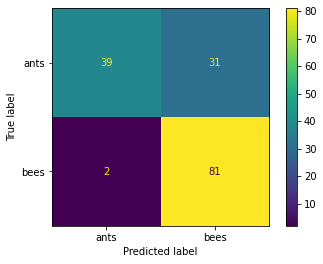

Accuracy: 0.869281045751634	F1 score: 0.880952380952381
              precision    recall  f1-score   support

        ants       0.87      0.84      0.86        70
        bees       0.87      0.89      0.88        83

    accuracy                           0.87       153
   macro avg       0.87      0.87      0.87       153
weighted avg       0.87      0.87      0.87       153



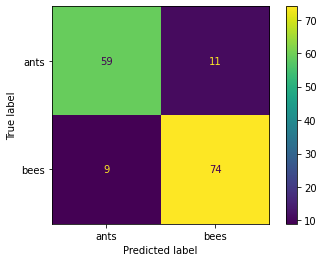

Accuracy: 0.8823529411764706	F1 score: 0.8875
              precision    recall  f1-score   support

        ants       0.84      0.91      0.88        70
        bees       0.92      0.86      0.89        83

    accuracy                           0.88       153
   macro avg       0.88      0.88      0.88       153
weighted avg       0.89      0.88      0.88       153



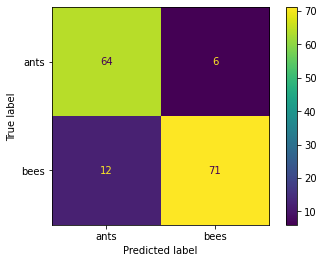

In [ ]:
# treating the validation dataset as testing
x_test, y_test = dataset['val'].drop(['Class'], axis=1), dataset['val']['Class']
# storing the predictions
preds = [model.predict(x_test) for model in models]
# calculating and displaying the performance
for i in range(len(preds)):
    print(f"Accuracy: {accuracy_score(y_test, preds[i])}\tF1 score: {f1_score(y_test, preds[i])}")
    print(classification_report(y_test, preds[i], target_names=class_names))
    ConfusionMatrixDisplay(confusion_matrix(y_test, preds[i]), display_labels=class_names).plot()
        # ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay
    plt.show()

This performance is really good considering the small no. training samples. The L2 regularized Logistic Regression performs the poorest followed by RBF kernel SVM and Random Forest being the best performer. Accuracy and F1 score are shown along with the confusion matrix and the classification report which contains some more performance parameters

Key Findings:
*  In real-life not all features are useful and many need to be removed or imputed thus, exploratory data analysis is a must.
*  Cross validation is helpful when the training dataset is small.
*  Feature importance should be kept in mind when furhter eliminating features.
*  Normalizing the dataset helps improve the model training time and performance.
*  Transfered learning can help train models when less data is available and the model performance is quite good.

References:
*  https://scikit-learn.org/stable/
*  https://www.geeksforgeeks.org/
*  https://pandas.pydata.org/docs/reference/index.html
*  https://stackoverflow.com/a/35598438
*  https://neptune.ai/blog/evaluation-metrics-binary-classification
*  https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd
*  https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
*  https://www.marktechpost.com/2019/06/07/how-to-connect-google-colab-with-google-drive/
*  https://stackoverflow.com/a/55098265
*  https://sparrow.dev/adding-a-dimension-to-a-tensor-in-pytorch/